In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
from pylab import rcParams
from keras.models import Sequential

from keras.layers import Dense, Dropout

Using TensorFlow backend.


In [4]:
%matplotlib inline

In [5]:
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

# Loading the data

The dataset we're going to use can be downloaded from [Kaggle](https://www.kaggle.com/dalpozz/creditcardfraud). It contains data about credit card transactions that occurred during a period of two days, with 492 frauds out of 284,807 transactions.

All variables in the dataset are numerical. The data has been transformed using PCA transformation(s) due to privacy reasons. The two features that haven't been changed are Time and Amount. Time contains the seconds elapsed between each transaction and the first transaction in the dataset.

In [6]:
df = pd.read_csv("creditcard.csv")

# Exploration

In [7]:
df.shape

(284807, 31)

In [9]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


31 columns, 2 of which are Time and Amount. The rest are output from the PCA transformation. Let's check for missing values:

In [10]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes

0    284315
1       492
Name: Class, dtype: int64

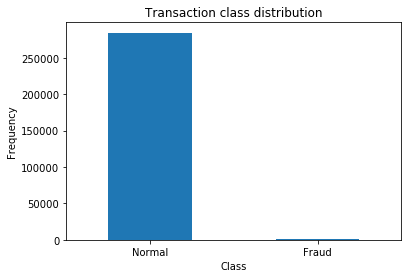

In [11]:
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

# Preparing the data

First, let's drop the Time column (not going to use it) and use the scikit's StandardScaler on the Amount. The scaler removes the mean and scales the values to unit variance:

In [12]:
from sklearn.preprocessing import StandardScaler

In [13]:
data = df.drop(['Time'], axis=1)
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [14]:
 data.loc[:,'V1':'Amount'].describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000
mean,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,...,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619
std,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,...,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109
min,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,...,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000
25%,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,...,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000
50%,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,...,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000
75%,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,...,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000
max,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,...,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000


In [15]:
data['Amount'].values

array([ 149.62,    2.69,  378.66, ...,   67.88,   10.  ,  217.  ])

In [16]:
data['Amount'].values.reshape(-1,1)

array([[ 149.62],
       [   2.69],
       [ 378.66],
       ..., 
       [  67.88],
       [  10.  ],
       [ 217.  ]])

In [17]:
data['Amount'].mean()

88.34961925087359

In [18]:
data['Amount'].std()

250.1201092402221

In [19]:
(data['Amount'] - 88.34961925087359)/250.1201092402221

0         0.244964
1        -0.342474
2         1.160684
3         0.140534
4        -0.073403
5        -0.338556
6        -0.333278
7        -0.190107
8         0.019392
9        -0.338516
10       -0.322044
11       -0.313288
12        0.132538
13       -0.243282
14       -0.118142
15       -0.289299
16       -0.301294
17       -0.349670
18       -0.166119
19       -0.333238
20        0.573166
21       -0.216934
22       -0.344113
23       -0.262272
24       -0.349670
25       -0.247560
26       -0.185789
27       -0.289260
28       -0.221292
29       -0.301294
            ...   
284777   -0.349231
284778   -0.033382
284779   -0.253277
284780   -0.233286
284781   -0.301254
284782   -0.301973
284783   -0.307411
284784   -0.193306
284785   -0.346072
284786   -0.317446
284787   -0.313288
284788   -0.337276
284789   -0.111345
284790   -0.314008
284791   -0.271988
284792   -0.337276
284793   -0.333278
284794   -0.349670
284795   -0.313768
284796   -0.113344
284797   -0.331279
284798   -0.

In [20]:
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data['Amount']

0         0.244964
1        -0.342475
2         1.160686
3         0.140534
4        -0.073403
5        -0.338556
6        -0.333279
7        -0.190107
8         0.019392
9        -0.338516
10       -0.322044
11       -0.313289
12        0.132538
13       -0.243282
14       -0.118142
15       -0.289300
16       -0.301294
17       -0.349671
18       -0.166119
19       -0.333239
20        0.573167
21       -0.216935
22       -0.344114
23       -0.262273
24       -0.349671
25       -0.247560
26       -0.185790
27       -0.289260
28       -0.221293
29       -0.301294
            ...   
284777   -0.349231
284778   -0.033382
284779   -0.253277
284780   -0.233287
284781   -0.301254
284782   -0.301974
284783   -0.307411
284784   -0.193306
284785   -0.346073
284786   -0.317447
284787   -0.313289
284788   -0.337277
284789   -0.111345
284790   -0.314008
284791   -0.271988
284792   -0.337277
284793   -0.333279
284794   -0.349671
284795   -0.313768
284796   -0.113344
284797   -0.331280
284798   -0.

Training our Autoencoder is gonna be a bit different from what we are used to. Let's say you have a dataset containing a lot of non fraudulent transactions at hand. You want to detect any anomaly on new transactions. We will create this situation by training our model on the normal transactions, only. Reserving the correct class on the test set will give us a way to evaluate the performance of our model. We will reserve 20% of our data for testing:

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
data = np.array(data)
data

array([[-1.35980713, -0.07278117,  2.53634674, ..., -0.02105305,
         0.24496426,  0.        ],
       [ 1.19185711,  0.26615071,  0.16648011, ...,  0.01472417,
        -0.34247454,  0.        ],
       [-1.35835406, -1.34016307,  1.77320934, ..., -0.05975184,
         1.16068593,  0.        ],
       ..., 
       [ 1.91956501, -0.30125385, -3.24963981, ..., -0.02656083,
        -0.0818393 ,  0.        ],
       [-0.24044005,  0.53048251,  0.70251023, ...,  0.10453282,
        -0.31324853,  0.        ],
       [-0.53341252, -0.18973334,  0.70333737, ...,  0.01364891,
         0.51435531,  0.        ]])

In [23]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)

In [24]:
X_train = X_train[X_train[:,-1] == 0]
X_train = X_train[:,:-1]

y_test = X_test[:,-1]
X_test = X_test[:,:-1]

In [25]:
X_train.shape


(227451, 29)

# Building the model

Building an autoencoder with 15 hidden layer neurons.

In [26]:
input_dim = X_train.shape[1]
encoding_dim = 15



autoencoder = Sequential()

autoencoder.add(Dropout(0.2, input_shape=(input_dim,)))
autoencoder.add(Dense(20, activation='sigmoid'))
autoencoder.add(Dense(encoding_dim, activation='relu'))
autoencoder.add(Dense(20, activation='sigmoid'))
autoencoder.add(Dense(input_dim, activation='linear'))



# Compiling the Model 
Let's train our model for 100 epochs with a batch size of 32 samples. Write the code for compiling and training the model

In [27]:


nb_epoch = 10
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['mse'])

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1).history







Train on 227451 samples, validate on 56962 samples
Epoch 1/10
227451/227451 [==============================] - 12s - loss: 0.6207 - mean_squared_error: 0.6207 - val_loss: 0.4570 - val_mean_squared_error: 0.4570
Epoch 2/10
227451/227451 [==============================] - 12s - loss: 0.4684 - mean_squared_error: 0.4684 - val_loss: 0.3725 - val_mean_squared_error: 0.3725
Epoch 3/10
227451/227451 [==============================] - 12s - loss: 0.4120 - mean_squared_error: 0.4120 - val_loss: 0.3286 - val_mean_squared_error: 0.3286
Epoch 4/10
227451/227451 [==============================] - 13s - loss: 0.3751 - mean_squared_error: 0.3751 - val_loss: 0.2886 - val_mean_squared_error: 0.2886
Epoch 5/10
227451/227451 [==============================] - 13s - loss: 0.3493 - mean_squared_error: 0.3493 - val_loss: 0.2742 - val_mean_squared_error: 0.2742
Epoch 6/10
227451/227451 [==============================] - 13s - loss: 0.3380 - mean_squared_error: 0.3380 - val_loss: 0.2652 - val_mean_squared_err

# Evaluation

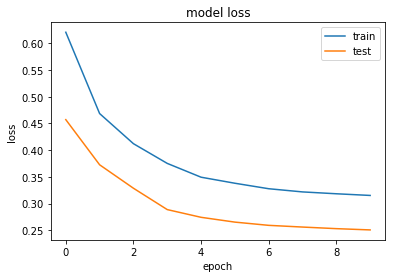

In [28]:
plt.plot(history['mean_squared_error'])
plt.plot(history['val_mean_squared_error'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

The reconstruction error on our training and test data seems to converge nicely. Is it low enough? Let's have a closer look at the error distribution:

In [ ]:
from sklearn.metrics import precision_score,recall_score

prc = list()
rec = list()
thres = list()

th = 0
for i in range(100):
    th+=0.1
    fraud = (test_recon>mean_recon+th)
    prc.append(precision_score(y_test,fraud))
    rec.append(recall_score(y_test,fraud))
    thres.append(th)
    

In [ ]:
plt.plot(prc, rec)
plt.title('precision vs recall')
plt.ylabel('recall')
plt.xlabel('precision')

In [ ]:
plt.plot(thres, rec)
plt.title('threshold vs recall')
plt.ylabel('recall')
plt.xlabel('threshold')

In [ ]:
plt.plot(thres, prc)
plt.title('threshold vs precision')
plt.ylabel('precision')
plt.xlabel('threshold')